Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.


  0%|          | 0/100 [00:00<?, ?it/s]

                              Feature  Importance  Percentage
20                          ethnicity    0.248731   31.742884
10                                age    0.046616    5.949151
8                            A9_Score    0.043300    5.525928
2                            A3_Score    0.043123    5.503274
5                            A6_Score    0.042584    5.434511
4                            A5_Score    0.041993    5.359094
3                            A4_Score    0.036627    4.674369
19                      relation_Self    0.036042    4.599649
11                           gender_m    0.035854    4.575607
6                            A7_Score    0.029943    3.821277
0                            A1_Score    0.027696    3.534588
9                           A10_Score    0.027361    3.491771
1                            A2_Score    0.025247    3.222046
7                            A8_Score    0.021050    2.686409
13                         austim_yes    0.016620    2.121008
12      

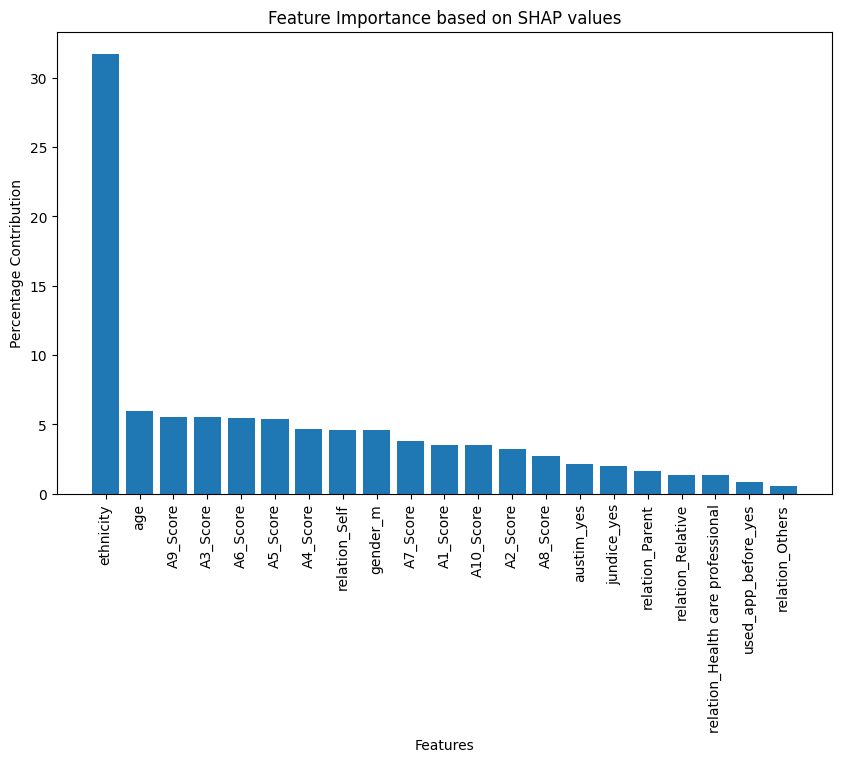

In [5]:
import pandas as pd
import numpy as np
from joblib import Parallel, delayed
from pymongo import MongoClient
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report, accuracy_score
import shap
import matplotlib.pyplot as plt


# Connect to MongoDB
client = MongoClient('mongodb://localhost:27017/')
db = client['thesis_db']  # Replace with your database name
collection = db['research_data']  # Replace with your collection name

# Retrieve data from MongoDB
data = list(collection.find())

# Convert to DataFrame
df = pd.DataFrame(data)

# Drop the MongoDB '_id' field if it exists
if '_id' in df.columns:
    df = df.drop('_id', axis=1)

# Data Cleaning and Preprocessing
df.fillna(df.mean(numeric_only=True), inplace=True)
df.drop_duplicates(inplace=True)
numeric_cols = df.select_dtypes(include=[float, int]).columns

# Parallelize outlier removal
def remove_outliers_iqr(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]

df_list = Parallel(n_jobs=-1)(delayed(remove_outliers_iqr)(df, col) for col in numeric_cols)
df = pd.concat(df_list)

scaler = StandardScaler()
df[numeric_cols] = scaler.fit_transform(df[numeric_cols])
label_encoder = LabelEncoder()
df['Class/ASD'] = label_encoder.fit_transform(df['Class/ASD'])

# One-hot encode categorical variables
df_encoded = pd.get_dummies(df, drop_first=True)

# Main attributes we are interested in
main_attributes = [
    'A1_Score', 'A2_Score', 'A3_Score', 'A4_Score', 'A5_Score', 
    'A6_Score', 'A7_Score', 'A8_Score', 'A9_Score', 'A10_Score', 
    'age', 'gender', 'ethnicity', 'jundice', 'austim', 
    'used_app_before',  'age_desc', 'relation', 'Class/ASD'
]

# Identify and filter columns based on main attributes
filtered_columns = [col for col in df_encoded.columns if any(col.startswith(attr) for attr in main_attributes)]
df_filtered = df_encoded[filtered_columns + ['Class/ASD']]

# Split the data into features and target
X = df_filtered.drop(columns=['Class/ASD'])
y = df_filtered['Class/ASD']

# Ensure the data is float32 for TensorFlow compatibility
X = X.astype('float32')
y = y.astype('float32')

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train a simple MLP model
model = MLPClassifier(hidden_layer_sizes=(100,), max_iter=500, random_state=42)
model.fit(X_train, y_train)

# Use a smaller subset for SHAP calculations if the dataset is large
X_train_subset = X_train.sample(n=100, random_state=42) if len(X_train) > 100 else X_train

# SHAP feature importance using KernelExplainer
explainer = shap.KernelExplainer(model.predict_proba, X_train_subset)
shap_values = explainer.shap_values(X_train_subset)

# Calculate mean absolute SHAP values for each feature
shap_values_mean = np.abs(shap_values[1]).mean(axis=0)
shap_importance = pd.DataFrame(list(zip(X.columns, shap_values_mean)), columns=['Feature', 'Importance'])

# Aggregate SHAP values for all ethnicity-related features
ethnicity_features = [col for col in shap_importance['Feature'] if 'ethnicity' in col]
ethnicity_importance = shap_importance[shap_importance['Feature'].isin(ethnicity_features)]['Importance'].sum()

# Filter out individual ethnicity features and add the aggregated feature
shap_importance = shap_importance[~shap_importance['Feature'].isin(ethnicity_features)]
ethnicity_row = pd.DataFrame({'Feature': ['ethnicity'], 'Importance': [ethnicity_importance]})
shap_importance = pd.concat([shap_importance, ethnicity_row], ignore_index=True)

# Sort by importance
shap_importance = shap_importance.sort_values(by='Importance', ascending=False)

# Calculate percentage contribution
shap_importance['Percentage'] = 100 * shap_importance['Importance'] / shap_importance['Importance'].sum()

# Save SHAP values to CSV
shap_importance.to_csv('shap_values.csv', index=False)

# Print the SHAP values DataFrame
print(shap_importance)

# Print the results for each feature
for index, row in shap_importance.iterrows():
    print(f"Feature: {row['Feature']}, Importance: {row['Importance']:.6f}, Percentage: {row['Percentage']:.6f}%")

# Plotting the SHAP values
plt.figure(figsize=(10, 6))
plt.bar(shap_importance['Feature'], shap_importance['Percentage'])
plt.xlabel('Features')
plt.ylabel('Percentage Contribution')
plt.title('Feature Importance based on SHAP values')
plt.xticks(rotation=90)
plt.show()
